# Пятая лабораторная работа

# Регрессия

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import  mean_squared_error, r2_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from math import sqrt
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler 

In [2]:
data = pd.read_csv('../data/mumbai_houses_task.csv')

*Корректировка названия столбцов*

In [3]:
data = data.rename(
    columns = {x: '_'.join(x.lower().split()) for x in data.columns}
)
data.columns

Index(['price', 'area', 'latitude', 'longitude', 'bedrooms', 'bathrooms',
       'balcony', 'status', 'neworold', 'parking', 'furnished_status', 'lift',
       'type_of_building'],
      dtype='object')

*Заполняем пропущенные значения*

In [4]:
data["furnished_status"] = data["furnished_status"].fillna("Unfurnished")
data["status"] = data["status"].fillna("Ready to Move")


*Удаление дубликатов*

In [5]:
print(data.duplicated().sum())
data = data.drop_duplicates().reset_index(drop= True)
print(data.duplicated().sum())

18
0


*Корректируем тип данных столбцов*

In [6]:
float_to_int = {"bedrooms", "bathrooms", "balcony", "parking", "lift"}
for field in float_to_int: 
    data[field] = data[field].astype(int)

dict_neworold = {"New Property": True, "Resale": False}
data["neworold"] = data["neworold"].map(dict_neworold)

dict_status = {"Ready to Move": True, "Under Construction": False}
data["status"] = data["status"].map(dict_status)

dict_furnished = {"Semi-Furnished": 0.5, "Furnished": 1, "Unfurnished": 0} 
data["furnished_status"] = data["furnished_status"].map(dict_furnished)

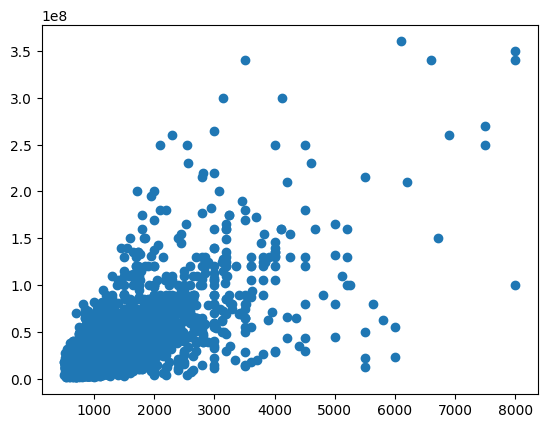

In [7]:
plt.scatter(x = data['area'], y = data['price'])

*Использование техники горячего кодирования*

In [8]:
numeric_data = data.select_dtypes(exclude='object')
object_data = data.select_dtypes(include='object')
data_objects_dummies = pd.get_dummies(object_data)
final_data = pd.concat([numeric_data,data_objects_dummies], axis=1)
final_data

price    area   latitude  longitude  bedrooms  bathrooms  balcony  \
0     22400000.0   629.0  19.032800  72.896357         2          2        0   
1     35000000.0   974.0  19.032800  72.896357         3          2        0   
2     31700000.0   968.0  19.085600  72.909277         3          3        0   
3     18700000.0   629.0  19.155756  72.846862         2          2        2   
4     13500000.0  1090.0  19.177555  72.849887         2          2        0   
...          ...     ...        ...        ...       ...        ...      ...   
6232  19500000.0   810.0  19.138320  72.810020         2          2        0   
6233  22000000.0  1400.0  19.221920  72.854250         3          3        1   
6234  20000000.0   750.0  19.144320  72.824111         2          2        0   
6235  11000000.0   700.0  19.047201  72.872225         2          2        0   
6236  15000000.0   900.0  19.168818  72.936375         2          2        0   

      status  neworold  parking  furnished_status  lift  \
0      False      True        0               0.0     0   
1      False      True        0               0.0     0   
2      False      True        0               0.0     0   
3       True      True        2               0.0     2   
4       True      True        0               0.0     0   
...      ...       ...      ...               ...   ...   
6232    True     False        0               0.5     0   
6233    True     False        1               0.0     1   
6234    True     False        0               0.0     0   
6235    True     False        0               1.0     0   
6236    True     False        0               0.0     0   

      type_of_building_Flat  type_of_building_Individual House  
0                         1                                  0  
1                         1                                  0  
2                         1                                  0  
3                         1                                  0  
4                         1                                  0  
...                     ...                                ...  
6232                      1                                  0  
6233                      1                                  0  
6234                      1                                  0  
6235                      1                                  0  
6236                      1                                  0  

[6237 rows x 14 columns]

In [9]:
# not_bool_data = data.select_dtypes(exclude='bool')
# bool_data = data.select_dtypes(include='bool')
# data_bool_dummies = pd.get_dummies(bool_data)
# final_data = pd.concat([not_bool_data, data_bool_dummies], axis=1)
# final_data

final_data = pd.get_dummies(final_data, columns = ['status', 'neworold'])
final_data

price    area   latitude  longitude  bedrooms  bathrooms  balcony  \
0     22400000.0   629.0  19.032800  72.896357         2          2        0   
1     35000000.0   974.0  19.032800  72.896357         3          2        0   
2     31700000.0   968.0  19.085600  72.909277         3          3        0   
3     18700000.0   629.0  19.155756  72.846862         2          2        2   
4     13500000.0  1090.0  19.177555  72.849887         2          2        0   
...          ...     ...        ...        ...       ...        ...      ...   
6232  19500000.0   810.0  19.138320  72.810020         2          2        0   
6233  22000000.0  1400.0  19.221920  72.854250         3          3        1   
6234  20000000.0   750.0  19.144320  72.824111         2          2        0   
6235  11000000.0   700.0  19.047201  72.872225         2          2        0   
6236  15000000.0   900.0  19.168818  72.936375         2          2        0   

      parking  furnished_status  lift  type_of_building_Flat  \
0           0               0.0     0                      1   
1           0               0.0     0                      1   
2           0               0.0     0                      1   
3           2               0.0     2                      1   
4           0               0.0     0                      1   
...       ...               ...   ...                    ...   
6232        0               0.5     0                      1   
6233        1               0.0     1                      1   
6234        0               0.0     0                      1   
6235        0               1.0     0                      1   
6236        0               0.0     0                      1   

      type_of_building_Individual House  status_False  status_True  \
0                                     0             1            0   
1                                     0             1            0   
2                                     0             1            0   
3                                     0             0            1   
4                                     0             0            1   
...                                 ...           ...          ...   
6232                                  0             0            1   
6233                                  0             0            1   
6234                                  0             0            1   
6235                                  0             0            1   
6236                                  0             0            1   

      neworold_False  neworold_True  
0                  0              1  
1                  0              1  
2                  0              1  
3                  0              1  
4                  0              1  
...              ...            ...  
6232               1              0  
6233               1              0  
6234               1              0  
6235               1              0  
6236               1              0  

[6237 rows x 16 columns]

Сохраняем предобработанные данные

In [4]:
final_data.to_csv("../data/regression_preprocessed_data", index=False)

NameError: name 'final_data' is not defined

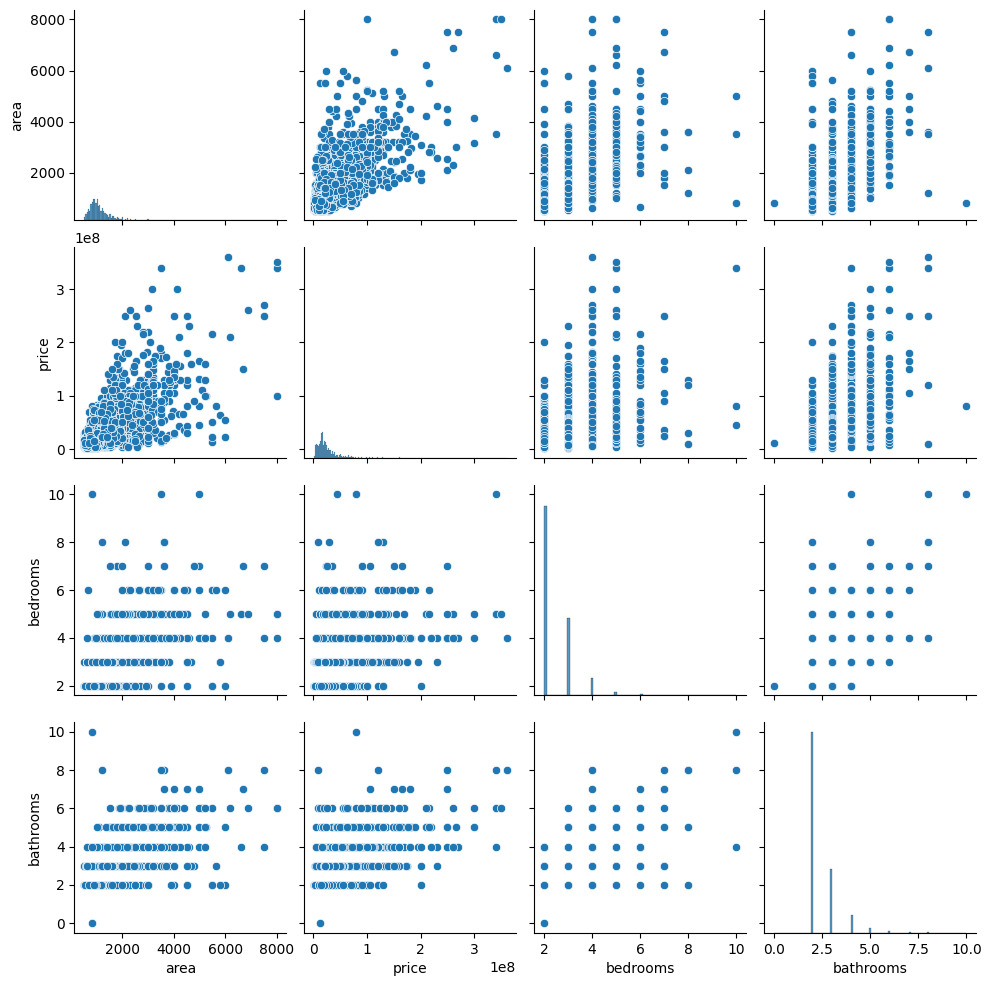

In [11]:
sns.pairplot(final_data[['area','price', 'bedrooms', 'bathrooms']], kind='scatter')

*Разбитие на выборки, на тестовую и обучающуюся*

In [3]:
y = final_data['price']
X = final_data.drop(['price'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 


NameError: name 'final_data' is not defined

In [13]:
final_data

price    area   latitude  longitude  bedrooms  bathrooms  balcony  \
0     22400000.0   629.0  19.032800  72.896357         2          2        0   
1     35000000.0   974.0  19.032800  72.896357         3          2        0   
2     31700000.0   968.0  19.085600  72.909277         3          3        0   
3     18700000.0   629.0  19.155756  72.846862         2          2        2   
4     13500000.0  1090.0  19.177555  72.849887         2          2        0   
...          ...     ...        ...        ...       ...        ...      ...   
6232  19500000.0   810.0  19.138320  72.810020         2          2        0   
6233  22000000.0  1400.0  19.221920  72.854250         3          3        1   
6234  20000000.0   750.0  19.144320  72.824111         2          2        0   
6235  11000000.0   700.0  19.047201  72.872225         2          2        0   
6236  15000000.0   900.0  19.168818  72.936375         2          2        0   

      parking  furnished_status  lift  type_of_building_Flat  \
0           0               0.0     0                      1   
1           0               0.0     0                      1   
2           0               0.0     0                      1   
3           2               0.0     2                      1   
4           0               0.0     0                      1   
...       ...               ...   ...                    ...   
6232        0               0.5     0                      1   
6233        1               0.0     1                      1   
6234        0               0.0     0                      1   
6235        0               1.0     0                      1   
6236        0               0.0     0                      1   

      type_of_building_Individual House  status_False  status_True  \
0                                     0             1            0   
1                                     0             1            0   
2                                     0             1            0   
3                                     0             0            1   
4                                     0             0            1   
...                                 ...           ...          ...   
6232                                  0             0            1   
6233                                  0             0            1   
6234                                  0             0            1   
6235                                  0             0            1   
6236                                  0             0            1   

      neworold_False  neworold_True  
0                  0              1  
1                  0              1  
2                  0              1  
3                  0              1  
4                  0              1  
...              ...            ...  
6232               1              0  
6233               1              0  
6234               1              0  
6235               1              0  
6236               1              0  

[6237 rows x 16 columns]

In [14]:
from sklearn.tree import DecisionTreeRegressor

In [15]:
dt_regressor = DecisionTreeRegressor()
dt_regressor.fit(X_train, y_train)

DecisionTreeRegressor()

### Прогнозируем на обучающейся выборке

In [16]:
y_pred_train = dt_regressor.predict(X_train)
r2_score(y_train, y_pred_train)

0.9998816981539416

### Прогнозы на тестовой выборке

In [17]:
y_pred = dt_regressor.predict(X_test)
r2_score(y_test, y_pred)

0.6217951830464551

Наложим друг на друга

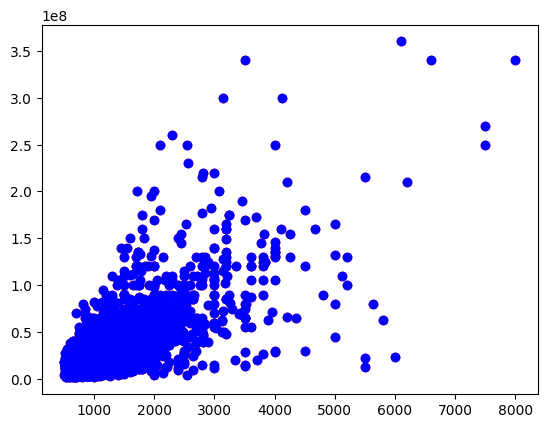

In [18]:
fig, ax = plt.subplots()
ax.scatter(X_train['area'],y_train, color = "red")

ax.scatter(X_train['area'],y_pred_train, color = "blue")

Такой хороший прогноз, что аж не видно красных точек

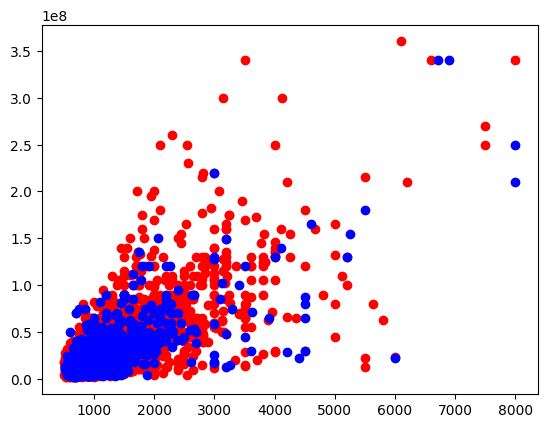

In [19]:
fig, ax = plt.subplots()
ax.scatter(X_train['area'],y_train, color = "red")

ax.scatter(X_test['area'],y_pred, color = "blue")

Теперь сравним два показателя R2

In [20]:
print(f'predict on a train data: {r2_score(y_test, y_pred)}')
print(f'predict on a test data: {r2_score(y_train, y_pred_train)}')

predict on a train data: 0.6217951830464551
predict on a test data: 0.9998816981539416


Видим, что они существенно различаются, что свидетельствует о переобучении (Это говорит о том, что модель слишком точно запоминает свойства обучающих данных, но не может обобщать эти свойства на новые данные.)

In [21]:
param_grid = {
    'max_depth': [2,3,4, 5],
    'max_features': ["sqrt", "log2", None],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [2, 3, 4],
    'criterion': ["squared_error", "friedman_mse", "absolute_error", "poisson"],
    'splitter': ["best", "random"],
    'ccp_alpha': [1, 5, 10, 100, 1000, None]
}


rand_search = RandomizedSearchCV(estimator = DecisionTreeRegressor(), param_distributions = param_grid, cv = 10, verbose = 2, scoring='r2',  n_jobs = -1, n_iter=20)
rand_search.fit(X_train, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[CV] END ccp_alpha=10, criterion=squared_error, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END ccp_alpha=10, criterion=squared_error, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END ccp_alpha=10, criterion=squared_error, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END ccp_alpha=10, criterion=squared_error, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END ccp_alpha=10, criterion=squared_error, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END ccp_alpha=10, criterion=squared_error, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END ccp_alpha=10, criterion=squared_error, max_depth=

/home/timofey/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
40 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/home/timofey/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/timofey/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py", line 1247, in fit
    super().fit(
  File "/home/timofey/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/home/timofey/.local/lib/python3.10/s

RandomizedSearchCV(cv=10, estimator=DecisionTreeRegressor(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'ccp_alpha': [1, 5, 10, 100, 1000,
                                                      None],
                                        'criterion': ['squared_error',
                                                      'friedman_mse',
                                                      'absolute_error',
                                                      'poisson'],
                                        'max_depth': [2, 3, 4, 5],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 3, 5],
                                        'min_samples_split': [2, 3, 4],
                                        'splitter': ['best', 'random']},
                   scoring='r2', verbose=2)

In [22]:
rand_search.best_params_

{'splitter': 'best',
 'min_samples_split': 2,
 'min_samples_leaf': 3,
 'max_features': 'log2',
 'max_depth': 5,
 'criterion': 'poisson',
 'ccp_alpha': 5}

Training r2

In [23]:
y_pred_train_optimized = rand_search.predict(X_train)
r2_score(y_train, y_pred_train_optimized)

0.5418456816646003

Testing r2

In [24]:
y_pred_optimized = rand_search.predict(X_test)
r2_score(y_test, y_pred_optimized)

0.5121472633463982

Результат значительно улучшился и результаты вполне сопоставимы и соразмеримы, и довольно близки, что свидетельствует о том, что gridsearch решил проблему переобучения

*Извлекаем лучший оценщик из randomizedsearch:*

In [25]:
best_tree_regressor = rand_search.best_estimator_

*Используем кросс-валидацию, чтобы посмотреть на несколько итераций и увидеть среднее значение оценки*

In [26]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=40, test_size=0.3, random_state=0)
cv_results = cross_validate(
    best_tree_regressor, X, y, cv=cv, scoring="r2"
)

In [27]:
cv_results = pd.DataFrame(cv_results)
cv_results.head()

fit_time  score_time  test_score
0  0.008750    0.002691    0.484792
1  0.006680    0.002571    0.531777
2  0.008810    0.003021    0.539497
3  0.005627    0.003019    0.459838
4  0.006978    0.002674    0.521702

In [28]:
cv_results['test_score'].mean()

0.49669441038648354

Видим, что значение приближено к полученному выше 

In [29]:
from sklearn import tree

In [30]:
print(tree.export_text(best_tree_regressor))

|--- feature_13 <= 0.50
|   |--- feature_1 <= 19.11
|   |   |--- feature_4 <= 3.50
|   |   |   |--- feature_0 <= 1297.50
|   |   |   |   |--- feature_4 <= 2.50
|   |   |   |   |   |--- value: [23236082.47]
|   |   |   |   |--- feature_4 >  2.50
|   |   |   |   |   |--- value: [30911538.46]
|   |   |   |--- feature_0 >  1297.50
|   |   |   |   |--- feature_4 <= 2.50
|   |   |   |   |   |--- value: [38126666.67]
|   |   |   |   |--- feature_4 >  2.50
|   |   |   |   |   |--- value: [51822222.22]
|   |   |--- feature_4 >  3.50
|   |   |   |--- feature_3 <= 4.50
|   |   |   |   |--- feature_8 <= 0.50
|   |   |   |   |   |--- value: [89414285.71]
|   |   |   |   |--- feature_8 >  0.50
|   |   |   |   |   |--- value: [85547619.05]
|   |   |   |--- feature_3 >  4.50
|   |   |   |   |--- feature_0 <= 3750.00
|   |   |   |   |   |--- value: [142500000.00]
|   |   |   |   |--- feature_0 >  3750.00
|   |   |   |   |   |--- value: [226666666.67]
|   |--- feature_1 >  19.11
|   |   |--- feature_0 <

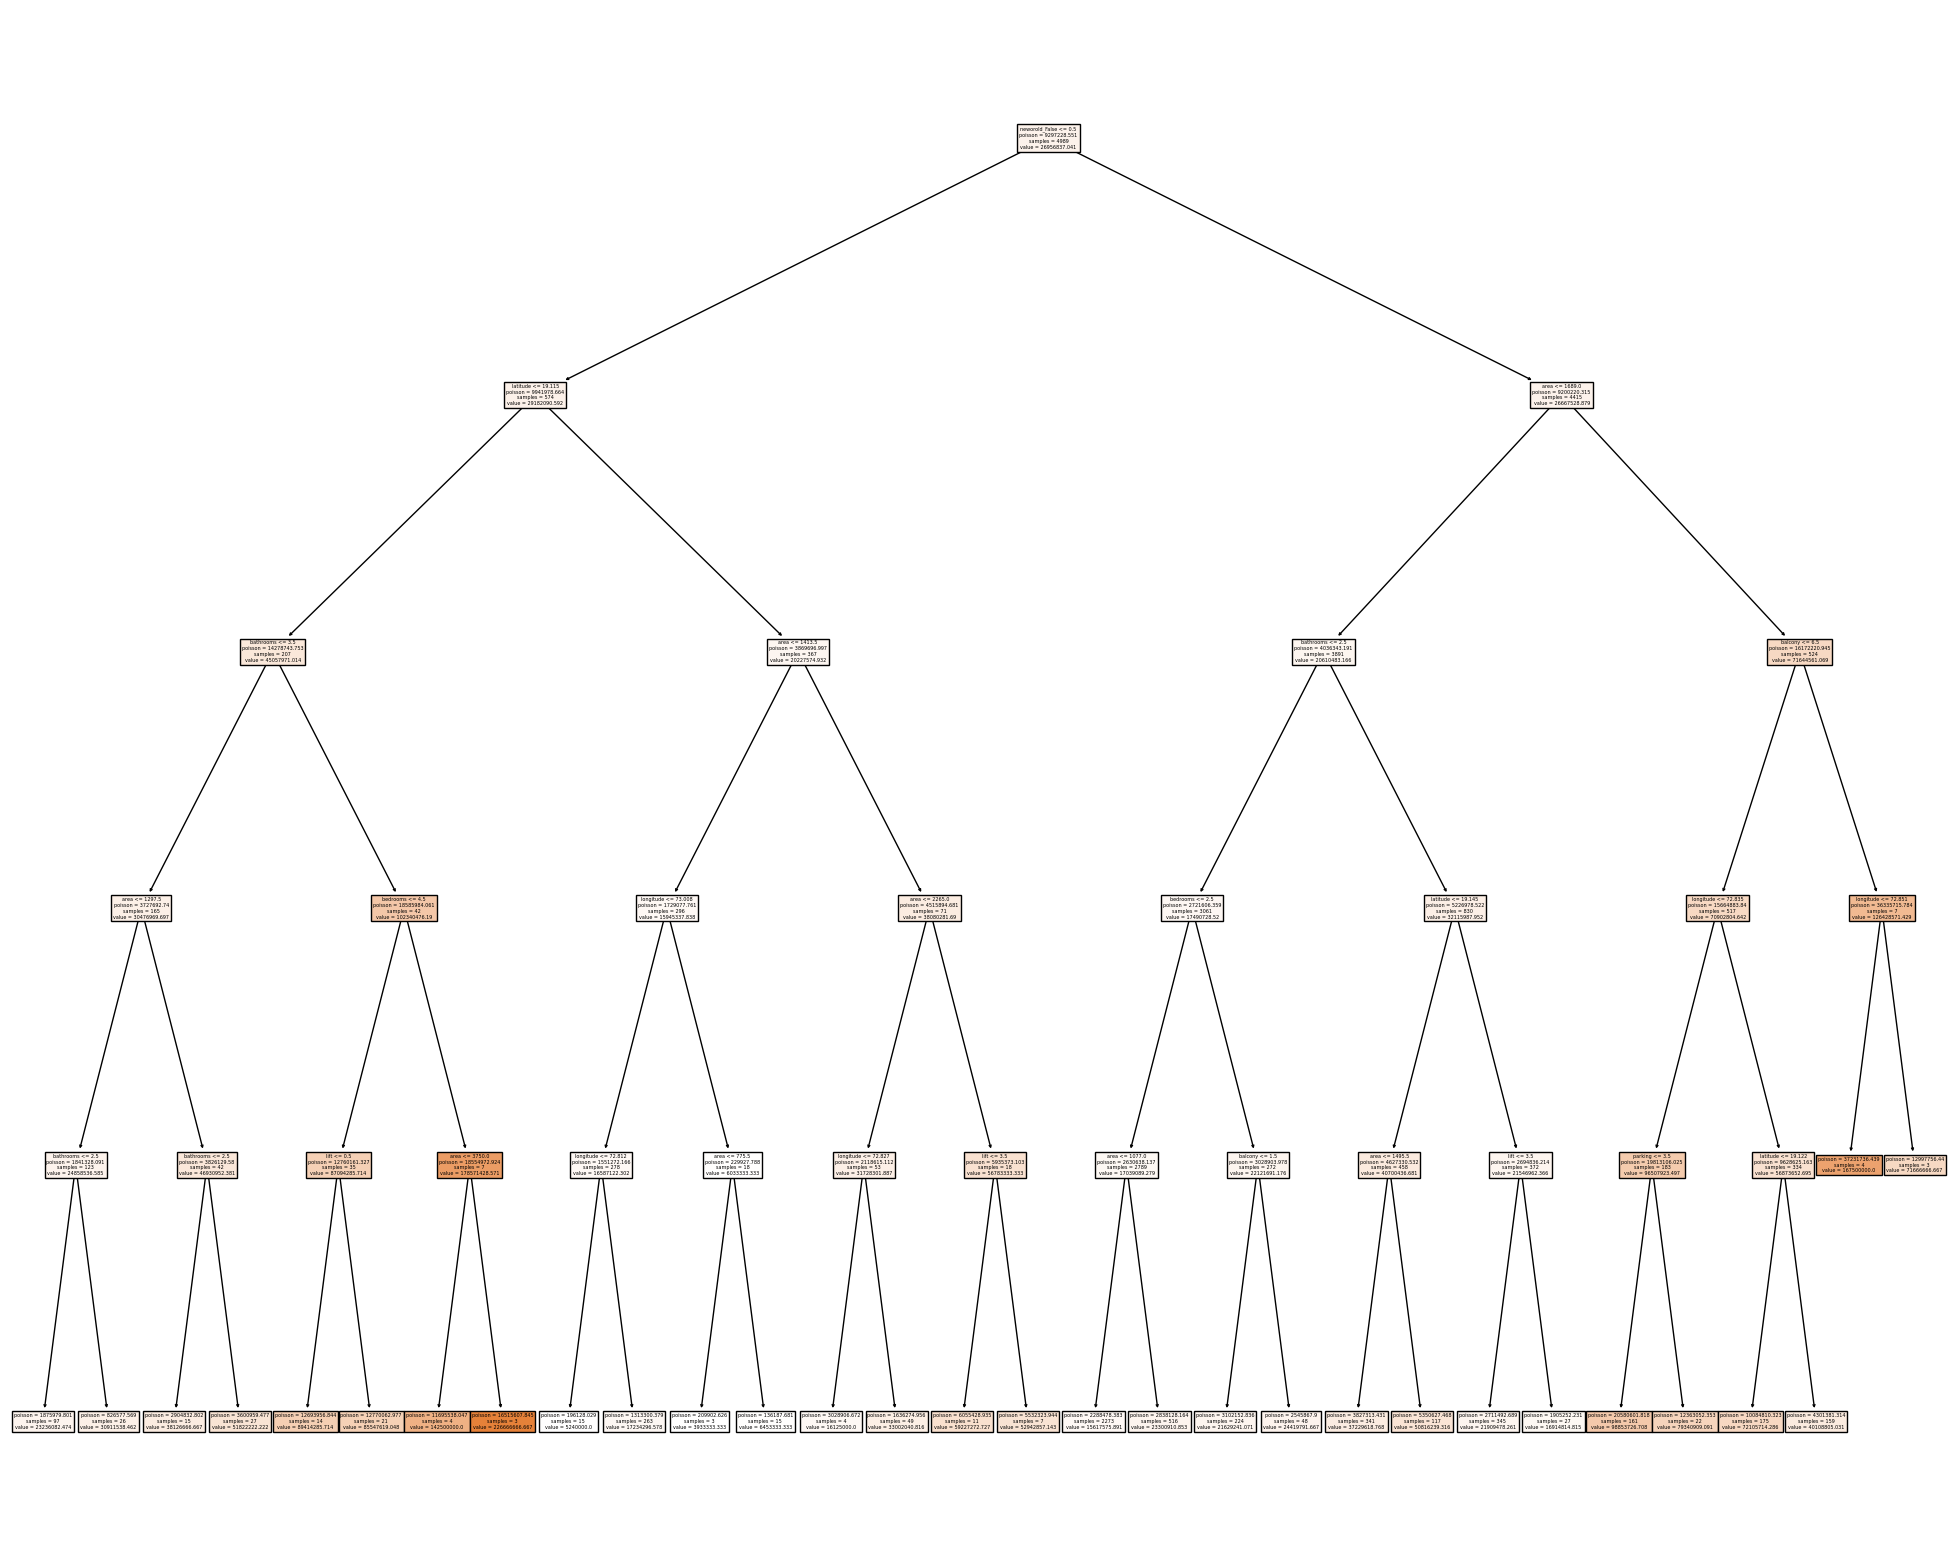

In [31]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(best_tree_regressor, feature_names=X.columns.to_list(), filled=True)

In [32]:
# %pip install --pre pycaret

In [33]:
from pycaret.utils import version
version()

'3.2.0'

In [34]:
from pycaret.regression import *

In [35]:
data1 = pd.read_csv('../data/mumbai_houses_task.csv')

In [36]:
data1.head()

price    area   latitude  longitude  Bedrooms  Bathrooms  Balcony  \
0  22400000.0   629.0  19.032800  72.896357       2.0        2.0      0.0   
1  35000000.0   974.0  19.032800  72.896357       3.0        2.0      0.0   
2  31700000.0   968.0  19.085600  72.909277       3.0        3.0      0.0   
3  18700000.0   629.0  19.155756  72.846862       2.0        2.0      2.0   
4  13500000.0  1090.0  19.177555  72.849887       2.0        2.0      0.0   

               Status      neworold  parking Furnished_status  Lift  \
0  Under Construction  New Property      0.0              NaN   0.0   
1  Under Construction  New Property      0.0              NaN   0.0   
2  Under Construction  New Property      0.0              NaN   0.0   
3       Ready to Move  New Property      2.0              NaN   2.0   
4                 NaN  New Property      0.0      Unfurnished   0.0   

  type_of_building  
0             Flat  
1             Flat  
2             Flat  
3             Flat  
4             Flat

In [37]:
setup(data=data1,  target='price',ignore_features=['longitude', 'latitude'], categorical_features=['Status', 'neworold', 'Furnished_status', 'type_of_building'] )


In [38]:
models()

Name  \
ID                                            
lr                        Linear Regression   
lasso                      Lasso Regression   
ridge                      Ridge Regression   
en                              Elastic Net   
lar                  Least Angle Regression   
llar           Lasso Least Angle Regression   
omp             Orthogonal Matching Pursuit   
br                           Bayesian Ridge   
ard       Automatic Relevance Determination   
par            Passive Aggressive Regressor   
ransac              Random Sample Consensus   
tr                       TheilSen Regressor   
huber                       Huber Regressor   
kr                             Kernel Ridge   
svm               Support Vector Regression   
knn                   K Neighbors Regressor   
dt                  Decision Tree Regressor   
rf                  Random Forest Regressor   
et                    Extra Trees Regressor   
ada                      AdaBoost Regressor   
gbr             Gradient Boosting Regressor   
mlp                           MLP Regressor   
xgboost           Extreme Gradient Boosting   
lightgbm    Light Gradient Boosting Machine   
catboost                 CatBoost Regressor   
dummy                       Dummy Regressor   

                                                  Reference  Turbo  
ID                                                                  
lr              sklearn.linear_model._base.LinearRegression   True  
lasso        sklearn.linear_model._coordinate_descent.Lasso   True  
ridge                     sklearn.linear_model._ridge.Ridge   True  
en        sklearn.linear_model._coordinate_descent.Elast...   True  
lar                  sklearn.linear_model._least_angle.Lars   True  
llar            sklearn.linear_model._least_angle.LassoLars   True  
omp       sklearn.linear_model._omp.OrthogonalMatchingPu...   True  
br                sklearn.linear_model._bayes.BayesianRidge   True  
ard               sklearn.linear_model._bayes.ARDRegression  False  
par       sklearn.linear_model._passive_aggressive.Passi...   True  
ransac         sklearn.linear_model._ransac.RANSACRegressor  False  
tr        sklearn.linear_model._theil_sen.TheilSenRegressor  False  
huber            sklearn.linear_model._huber.HuberRegressor   True  
kr                         sklearn.kernel_ridge.KernelRidge  False  
svm                                sklearn.svm._classes.SVR  False  
knn       sklearn.neighbors._regression.KNeighborsRegressor   True  
dt              sklearn.tree._classes.DecisionTreeRegressor   True  
rf           sklearn.ensemble._forest.RandomForestRegressor   True  
et             sklearn.ensemble._forest.ExtraTreesRegressor   True  
ada       sklearn.ensemble._weight_boosting.AdaBoostRegr...   True  
gbr          sklearn.ensemble._gb.GradientBoostingRegressor   True  
mlp       sklearn.neural_network._multilayer_perceptron....  False  
xgboost                        xgboost.sklearn.XGBRegressor   True  
lightgbm                     lightgbm.sklearn.LGBMRegressor   True  
catboost                    catboost.core.CatBoostRegressor   True  
dummy                          sklearn.dummy.DummyRegressor   True

In [39]:
dt = create_model(estimator='dt')

In [40]:
tuned_dt = tune_model(dt)

Initiated  . . . . . . . . . . . . . . . . . .                   17:29:42
Status     . . . . . . . . . . . . . . . . . .  Searching Hyperparameters
Estimator  . . . . . . . . . . . . . . . . . .    Decision Tree Regressor

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Таким образом средний r2 показатель равняется 0.47, а полученное нами значение в cross-validation: 0.68, а у модели, параметры которой подобрали с помощью gridsearch: 0.65. 

## Применение ансамблей в регрессии

*BaggingRegressor*

In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.kernel_ridge import KernelRidge

from sklearn.preprocessing import RobustScaler

from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, StackingRegressor

In [42]:
def regression_metrics(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    scores = {}
    scores['mean_squared_error'] = mean_squared_error(y_test, y_pred)
    scores['r2_score'] =  r2_score(y_test, y_pred)
    
    return scores
    

In [43]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4989 entries, 5700 to 5075
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   area                               4989 non-null   float64
 1   latitude                           4989 non-null   float64
 2   longitude                          4989 non-null   float64
 3   bedrooms                           4989 non-null   int64  
 4   bathrooms                          4989 non-null   int64  
 5   balcony                            4989 non-null   int64  
 6   parking                            4989 non-null   int64  
 7   furnished_status                   4989 non-null   float64
 8   lift                               4989 non-null   int64  
 9   type_of_building_Flat              4989 non-null   uint8  
 10  type_of_building_Individual House  4989 non-null   uint8  
 11  status_False                       4989 non-null   ui

In [44]:
linear = make_pipeline(LinearRegression())
regression_metrics(linear)

{'mean_squared_error': 229623700570435.34, 'r2_score': 0.6724025690308167}

In [45]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.1))
regression_metrics(lasso)

{'mean_squared_error': 229623705422521.72, 'r2_score': 0.6724025621084868}

In [46]:
elastic_net = make_pipeline(RobustScaler(), ElasticNet(alpha=0.1)) 
regression_metrics(elastic_net)

{'mean_squared_error': 229092156999185.78, 'r2_score': 0.6731609067283495}

In [47]:
kernel_ridge = make_pipeline(RobustScaler(), KernelRidge(alpha=0.5, kernel="polynomial", degree=2, coef0=2.5))
regression_metrics(kernel_ridge)


{'mean_squared_error': 162540992449294.22, 'r2_score': 0.7681075105867098}

In [48]:
list(kernel_ridge.named_steps.keys())[1]

'kernelridge'

In [49]:
best_tree_regressor

DecisionTreeRegressor(ccp_alpha=5, criterion='poisson', max_depth=5,
                      max_features='log2', min_samples_leaf=3)

In [50]:
def bagging_predictions(estimator):
    regr = BaggingRegressor(base_estimator=estimator,
                            n_estimators=10,
                            max_samples=1.0,
                            bootstrap=True, # Samples are drawn with replacement
                            n_jobs= -1,
                            random_state= 43).fit(X_train, y_train)

    br_y_pred = regr.predict(X_test)
    return br_y_pred

In [51]:
predictions = np.column_stack((bagging_predictions(linear), # составляет их столбами поэлементно
                              bagging_predictions(lasso),
                              bagging_predictions(elastic_net),
                              bagging_predictions(kernel_ridge),
                              bagging_predictions(best_tree_regressor)))
predictions   

array([[5.32891205e+07, 5.32891197e+07, 5.15386648e+07, 4.90979561e+07,
        4.73406373e+07],
       [3.54715310e+07, 3.54715307e+07, 3.54873886e+07, 3.00795597e+07,
        2.77049694e+07],
       [1.06852606e+07, 1.06852606e+07, 1.09187055e+07, 1.19051347e+07,
        1.67223136e+07],
       ...,
       [7.55962555e+07, 7.55962566e+07, 7.44898396e+07, 9.47892515e+07,
        1.00917580e+08],
       [1.44347477e+07, 1.44347484e+07, 1.48577226e+07, 1.64038569e+07,
        1.64957827e+07],
       [1.05777869e+07, 1.05777880e+07, 1.10762471e+07, 1.46011329e+07,
        1.78197624e+07]])

In [52]:
y_pred = np.mean(predictions, axis=1)
r2 = r2_score(y_pred, y_test)

In [53]:
r2

0.6155535975352051

trying with the only base estimator (as it prolly should've been)

In [56]:
regr = BaggingRegressor(base_estimator=kernel_ridge,
                            n_estimators=100,
                            max_samples=1.0,
                            bootstrap=True, # Samples are drawn with replacement
                            n_jobs= -1,
                            random_state= 43).fit(X_train, y_train)

br_y_pred = regr.predict(X_test)

In [57]:
r2_score(br_y_pred, y_test)

0.734683770975721

In [58]:
import joblib

joblib.dump(regr, "../models/MODEL_FOUR_bagging_regressor")

['../models/MODEL_FOUR_bagging_regressor']

In [59]:
test = joblib.load("../models/MODEL_FOUR_bagging_regressor")
r2_score(test.predict(X_test), y_test)

0.734683770975721

In [51]:
regression_ensemble_scores = {'BaggingRegressor': r2}

*GradientBoostingRegressor*

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

regression = pd.read_csv('../data/regression_preprocessed_data')
X = regression.drop(columns= 'price')
y = regression['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .3)

In [8]:
gradient_boosting_regressor= GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state = 42)

In [9]:
gradient_boosting_regressor.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, loss='huber', max_depth=4,
                          max_features='sqrt', min_samples_leaf=15,
                          min_samples_split=10, n_estimators=3000,
                          random_state=42)

In [11]:
from sklearn.metrics import r2_score
y_pred = gradient_boosting_regressor.predict(X_test)
r2_score(y_pred, y_test)

0.7139439309201892

In [13]:
import joblib
joblib.dump(gradient_boosting_regressor, '../models/MODEL_TWO_gradient_boosting_regressor')

['../models/MODEL_TWO_gradient_boosting_regressor']

In [15]:
test = joblib.load('../models/MODEL_TWO_gradient_boosting_regressor')
r2_score(test.predict(X_test), y_test)

0.7139439309201892

In [53]:
regression_metrics(gradient_boosting_regressor)

{'mean_squared_error': 188608871830026.2, 'r2_score': 0.7584514942207502}

Теперь с RandomizedSearch:

In [54]:
param_grid = {
    'n_estimators': [ 1000, 3000],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3], 
    'max_features': ['sqrt'],
    'random_state': [42],
    'min_samples_leaf': [10, 15, 20],
    'min_samples_split': [10, 15],
    'loss': ['huber', 'squared_error']
}


rand_search = RandomizedSearchCV(estimator = GradientBoostingRegressor(), param_distributions = param_grid, 
                   cv = 10, verbose = 2, scoring='r2',  n_jobs = -1)
regression_metrics(rand_search)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END learning_rate=0.1, loss=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=3000, random_state=42; total time=   8.4s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=3000, random_state=42; total time=   8.8s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=3000, random_state=42; total time=   9.4s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=3000, random_state=42; total time=  10.0s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=3000, random_state=42; total time=   8.3s
[CV] END learning_rate=0.1, loss=squared_error,

KeyboardInterrupt: 

In [ ]:
y_pred = rand_search.predict(X_test)
r2 = r2_score(y_test, y_pred)
r2

0.815687198802656

In [ ]:
regression_ensemble_scores['GradientBoostingRegressor'] = r2

*StackingRegressor*

In [64]:
estimators = [ ('elastic_net', elastic_net), ('kernel_ridge', kernel_ridge),('decision_tree_regressor', best_tree_regressor) ]
stacking_reg = StackingRegressor(estimators=estimators, final_estimator= lasso, cv= 5, 
                  n_jobs= -1, # this param cotrols th parallel processing, -1 means using all processors 
                  passthrough = True)

In [65]:
stacking_reg.fit(X_train, y_train)

StackingRegressor(cv=5,
                  estimators=[('elastic_net',
                               Pipeline(steps=[('robustscaler', RobustScaler()),
                                               ('elasticnet',
                                                ElasticNet(alpha=0.1))])),
                              ('kernel_ridge',
                               Pipeline(steps=[('robustscaler', RobustScaler()),
                                               ('kernelridge',
                                                KernelRidge(alpha=0.5,
                                                            coef0=2.5, degree=2,
                                                            kernel='polynomial'))])),
                              ('decision_tree_regressor',
                               DecisionTreeRegressor(ccp_alpha=5,
                                                     criterion='poisson',
                                                     max_depth=5,
                                                     max_features='log2',
                                                     min_samples_leaf=3))],
                  final_estimator=Pipeline(steps=[('robustscaler',
                                                   RobustScaler()),
                                                  ('lasso', Lasso(alpha=0.1))]),
                  n_jobs=-1, passthrough=True)

In [92]:
y_pred = stacking_reg.predict(X_test)
r2 = r2_score(y_test, y_pred)
r2

0.7650697172609244

In [95]:
import joblib

joblib.dump(stacking_reg, "../models/MODEL_FIVE_stacking_regressor") 

test = joblib.load("../models/MODEL_FIVE_stacking_regressor")
r2_score(test.predict(X_test), y_test)

0.7178441071876464

C RandomizedSearch:

In [90]:
params = {
    'cv': [5],
    'passthrough': [True, False],
    'n_jobs': [-1],
    'final_estimator': [lasso]
}


rand_search = RandomizedSearchCV(estimator = StackingRegressor(estimators=estimators), param_distributions = params, 
                   cv = 5, scoring='r2',  n_jobs = -1)
rand_search.fit(X_train, y_train)

KeyboardInterrupt: 

In [84]:
rand_search.best_params_

{'passthrough': False, 'n_jobs': -1, 'cv': 5}

In [69]:
y_pred = rand_search.predict(X_test)
r2 = r2_score(y_test, y_pred)
r2

0.7672614393736596

['../models/MODEL_FIVE_stacking_regressor']

0.7163151356698387

In [ ]:
regression_ensemble_scores['StackingRegressor'] = r2

Выбор лучшего ансамбля:

In [ ]:
regression_ensemble_scores

{'BaggingRegressor': 0.5904517280485041,
 'GradientBoostingRegressor': 0.815687198802656,
 'StackingRegressor': 0.7406711789909852}

Видим, что благодаря большей вариативности параметров градиентный бустинг показал наилучший результат 

### Catboost, XGBoost, LightGBM (regression)

*Catboost*

In [ ]:
# %pip install catboost

In [ ]:
from catboost import CatBoostRegressor

In [ ]:
categorical = {key:X.dtypes[key] for key in X.dtypes.to_dict() if key not in  {'area', 'latitude', 'longitude'}}
categorical = pd.Series(categorical)

cat_indices = [i for i in range(len(X.dtypes)) if X.columns[i] not in {'area', 'latitude', 'longitude', 'furnished_status'}]

bedrooms                               int64
bathrooms                              int64
balcony                                int64
status                                  bool
neworold                                bool
parking                                int64
furnished_status                     float64
lift                                   int64
type_of_building_Flat                  uint8
type_of_building_Individual House      uint8
dtype: object

In [ ]:
catboost_regressor = CatBoostRegressor(iterations=50, loss_function='RMSE')


In [ ]:
catboost_regressor.fit(    
     X_train,
     y_train,
     cat_features=cat_indices,
     eval_set=(X_test, y_test),
     verbose=False,
     plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
y_pred = catboost_regressor.predict(X_test)
r2 = r2_score(y_pred, y_test)
r2

0.7514492573420553

In [ ]:
np.linspace(3, 3.5, 5)

array([3.   , 3.125, 3.25 , 3.375, 3.5  ])

In [ ]:
params = {'n_estimators': [298, 500, 1000], 
          'max_depth': [3, 4], 
          'subsample':  [0.5, 0.8], #np.linspace(0.55, 0.6, 10), 
          'l2_leaf_reg': [1, 3, 5, 7, 9], #np.linspace(3, 3.5, 5), 
          'random_strength': [1, 4, 7], #np.linspace(1.1, 1.2, 10), 
          'eta':  [0.1, 0.4, 0.7],#np.linspace(0.09, 0.1, 10), 
          'min_data_in_leaf': [5], 
          'random_state': [43]}

rand_search = RandomizedSearchCV(estimator = CatBoostRegressor(), param_distributions = params, 
                   cv = 10, scoring='r2',  n_jobs = -1)
rand_search.fit(X_train, y_train)

0:	learn: 27481944.9121855	total: 47.6ms	remaining: 23.7s
1:	learn: 26501039.1688018	total: 48.9ms	remaining: 12.2s
2:	learn: 25319024.6443669	total: 59.6ms	remaining: 9.87s
3:	learn: 24249387.4852210	total: 83.1ms	remaining: 10.3s
4:	learn: 23273350.0214093	total: 89.4ms	remaining: 8.85s
5:	learn: 22496007.7055252	total: 91ms	remaining: 7.49s
6:	learn: 21728131.7570528	total: 97.4ms	remaining: 6.86s
7:	learn: 20978078.2218156	total: 112ms	remaining: 6.86s
8:	learn: 20316692.7049401	total: 113ms	remaining: 6.17s
9:	learn: 19818736.5501693	total: 115ms	remaining: 5.62s
10:	learn: 19399276.7141458	total: 131ms	remaining: 5.82s
11:	learn: 18898024.1634281	total: 132ms	remaining: 5.38s
12:	learn: 18438111.9281136	total: 141ms	remaining: 5.29s
13:	learn: 17989271.9420960	total: 143ms	remaining: 4.96s
14:	learn: 17655014.6283160	total: 153ms	remaining: 4.94s
15:	learn: 17325285.3627616	total: 154ms	remaining: 4.66s
16:	learn: 16996152.6869482	total: 167ms	remaining: 4.76s
17:	learn: 16722892

RandomizedSearchCV(cv=10,
                   estimator=<catboost.core.CatBoostRegressor object at 0x7f0099e363b0>,
                   n_jobs=-1,
                   param_distributions={'eta': [0.1, 0.4, 0.7],
                                        'l2_leaf_reg': [1, 3, 5, 7, 9],
                                        'max_depth': [3, 4],
                                        'min_data_in_leaf': [5],
                                        'n_estimators': [298, 500, 1000],
                                        'random_state': [43],
                                        'random_strength': [1, 4, 7],
                                        'subsample': [0.5, 0.8]},
                   scoring='r2')

In [ ]:
rand_search.best_params_

{'subsample': 0.8,
 'random_strength': 4,
 'random_state': 43,
 'n_estimators': 500,
 'min_data_in_leaf': 5,
 'max_depth': 3,
 'l2_leaf_reg': 9,
 'eta': 0.1}

In [ ]:
y_pred = rand_search.predict(X_test)
r2 = r2_score(y_pred, y_test)
r2

0.765863458383705

In [ ]:
boosts_scores = {'CatBoost': r2}
boosts_scores

{'CatBoost': 0.765863458383705}

*XGBoost*

In [ ]:
# %pip install xgboost 

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import xgboost as xgb

In [ ]:
xgb_regressor= xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213,verbosity=0, nthread = -1, random_state = 42)

In [ ]:
xgb_regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.4603, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.0468, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1.7817, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2200, n_jobs=None, nthread=-1,
             num_parallel_tree=None, ...)

In [ ]:
y_pred = xgb_regressor.predict(X_test)
r2 = r2_score(y_pred, y_test)
r2

0.7145572935855355

**with *RandomizedSearch*:**

In [ ]:
params = {
    'colsample_bytree': [0.4603, 0.2, 0.8], 
    'gamma': [0.0468, 0.09], 
    'learning_rate': [0.05, 0.1], 
    'max_depth': [3, 4], 
    'min_child_weight': [1.7817], 
    'n_estimators': [2200],
    'reg_alpha': [0.4640, 0.7], 
    'reg_lambda': [0.8571, 0.3],
    'subsample': [0.5213], 
    'verbosity': [0], 
    'nthread':  [-1],
}


rand_search = RandomizedSearchCV(estimator = xgb_regressor, param_distributions = params, 
                   cv = 10, scoring='r2',  n_jobs = -1)
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=0.4603, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=0.0468, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_...
                                          n_estimators=2200, n_jobs=None,
                                          nthread=-1, num_parallel_tree=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.4603, 0.2, 0.8],
                                        'gamma': [0.0468, 0.09],
                                        'learning_rate': [0.05, 0.1],
                                        'max_depth': [3, 4],
                                        'min_child_weight': [1.7817],
                                        'n_estimators': [2200], 'nthread': [-1],
                                        'reg_alpha': [0.464, 0.7],
                                        'reg_lambda': [0.8571, 0.3],
                                        'subsample': [0.5213],
                                        'verbosity': [0]},
                   scoring='r2')

In [ ]:
rand_search.best_params_

{'verbosity': 0,
 'subsample': 0.5213,
 'reg_lambda': 0.8571,
 'reg_alpha': 0.464,
 'nthread': -1,
 'n_estimators': 2200,
 'min_child_weight': 1.7817,
 'max_depth': 4,
 'learning_rate': 0.05,
 'gamma': 0.09,
 'colsample_bytree': 0.4603}

In [ ]:
y_pred = rand_search.predict(X_test)
r2 = r2_score(y_test, y_pred)
r2

0.7444523009240508

In [ ]:
boosts_scores['XGBoost'] = r2

*LGBMRegressor*

In [ ]:
import lightgbm as lgb

In [ ]:
lgbm_regressor= lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11,random_state = 43)

In [ ]:
lgbm_regressor.fit(X_train, y_train)

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsa

LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
              feature_fraction=0.2319, feature_fraction_seed=9,
              learning_rate=0.05, max_bin=55, min_data_in_leaf=6,
              min_sum_hessian_in_leaf=11, n_estimators=720, num_leaves=5,
              objective='regression', random_state=43)

In [ ]:
y_pred = lgbm_regressor.predict(X_test)
r2 = r2_score(y_test, y_pred)
r2

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


0.7598504539550366

In [ ]:
boosts_scores['LGBMRegressor'] = r2

*Сравниваем*

In [ ]:
boosts_scores

{'CatBoost': 0.765863458383705,
 'XGBoost': 0.7444523009240508,
 'LGBMRegressor': 0.7598504539550366}

CatBoost показала результат лучше остальных

# Классификация

In [57]:
data = pd.read_csv('../data/smoke_detector_task.csv')
data = data.drop(['Unnamed: 0'], axis=1)
data = data.drop('UTC', axis=1)

In [58]:
mean_group = ["TVOC[ppb]", "eCO2[ppm]", "PM2.5", 
              "NC1.0", "Humidity[%]", "Temperature[C]",
                "Raw H2", "Pressure[hPa]"]

for field in mean_group:
    data[field] = data[field].fillna(data[field].mean())

In [59]:
dict_firealarm = {"Yes": True, "No": False}
data["Fire Alarm"] = data["Fire Alarm"].map(dict_firealarm)

In [2]:
import pandas as pd

In [3]:
data = pd.read_csv('../data/smoke_detector_task.csv')
data = data.drop(['Unnamed: 0'], axis=1)
data = data.drop('UTC', axis=1)

mean_group = ["TVOC[ppb]", "eCO2[ppm]", "PM2.5", 
              "NC1.0", "Humidity[%]", "Temperature[C]",
                "Raw H2", "Pressure[hPa]"]

for field in mean_group:
    data[field] = data[field].fillna(data[field].mean())

dict_firealarm = {"Yes": 1, "No": 0}
data["Fire Alarm"] = data["Fire Alarm"].map(dict_firealarm)

data = data.rename(
    columns = {"TVOC[ppb]": "TVOC", "eCO2[ppm]": "eCO2", "Humidity[%]": "Humidity", 
               "Temperature[C]": "Temperature", "Pressure[hPa]": "Pressure"}
)

data = data.drop(columns= 'CNT')


In [4]:
data

Temperature  Humidity   TVOC   eCO2   Raw H2  Raw Ethanol  Pressure  \
0           20.000     57.36    0.0  400.0  12306.0        18520   939.735   
1           20.015     56.67    0.0  400.0  12345.0        18651   939.744   
2           20.029     55.96    0.0  400.0  12374.0        18764   939.738   
3           20.044     55.28    0.0  400.0  12390.0        18849   939.736   
4           20.059     54.69    0.0  400.0  12403.0        18921   939.744   
...            ...       ...    ...    ...      ...          ...       ...   
62625       18.438     15.79  625.0  400.0  13723.0        20569   936.670   
62626       18.653     15.87  612.0  400.0  13731.0        20588   936.678   
62627       18.867     15.84  627.0  400.0  13725.0        20582   936.687   
62628       19.083     16.04  638.0  400.0  13712.0        20566   936.680   
62629       19.299     16.52  643.0  400.0  13696.0        20543   936.676   

       PM1.0  PM2.5  NC0.5  NC1.0  NC2.5  Fire Alarm  
0       0.00   0.00   0.00  0.000  0.000           0  
1       0.00   0.00   0.00  0.000  0.000           0  
2       0.00   0.00   0.00  0.000  0.000           0  
3       0.00   0.00   0.00  0.000  0.000           0  
4       0.00   0.00   0.00  0.000  0.000           0  
...      ...    ...    ...    ...    ...         ...  
62625   0.63   0.65   4.32  0.673  0.015           0  
62626   0.61   0.63   4.18  0.652  0.015           0  
62627   0.57   0.60   3.95  0.617  0.014           0  
62628   0.57   0.59   3.92  0.611  0.014           0  
62629   0.57   0.59   3.90  0.607  0.014           0  

[62630 rows x 13 columns]

In [ ]:
data.to_csv("../data/classification_preprocessed_data", index=False)

In [61]:
data.head()

Temperature  Humidity  TVOC   eCO2   Raw H2  Raw Ethanol  Pressure  PM1.0  \
0       20.000     57.36   0.0  400.0  12306.0        18520   939.735    0.0   
1       20.015     56.67   0.0  400.0  12345.0        18651   939.744    0.0   
2       20.029     55.96   0.0  400.0  12374.0        18764   939.738    0.0   
3       20.044     55.28   0.0  400.0  12390.0        18849   939.736    0.0   
4       20.059     54.69   0.0  400.0  12403.0        18921   939.744    0.0   

   PM2.5  NC0.5  NC1.0  NC2.5  CNT  Fire Alarm  
0    0.0    0.0    0.0    0.0    0           0  
1    0.0    0.0    0.0    0.0    1           0  
2    0.0    0.0    0.0    0.0    2           0  
3    0.0    0.0    0.0    0.0    3           0  
4    0.0    0.0    0.0    0.0    4           0

In [63]:
outliers = data.drop(['Fire Alarm'], axis=1)

Q1 = outliers.quantile(0.25)
Q3 = outliers.quantile(0.75)
IQR = Q3-Q1
filtered_data = outliers[~((outliers < (Q1 - 1.5 * IQR)) |(outliers > (Q3 + 1.5 * IQR))).any(axis=1)]
index_list = filtered_data.index.values
filtered_data = data[data.index.isin(index_list)]

## DecisionTreeClassifier из Sklearn. Сравнение с PyCaret

### **С УДАЛЕНИЕМ ВЫБРОСОВ**

In [64]:
 
y = filtered_data['Fire Alarm'] 
X = filtered_data.drop(['Fire Alarm'], axis=1) 

X, y = RandomOverSampler(random_state=42).fit_resample(X, y) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

In [65]:
y.value_counts()

0    30419
1    30419
Name: Fire Alarm, dtype: int64

In [66]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

In [72]:
simple_model = DecisionTreeClassifier(max_depth=3)
simple_model.fit(X_train, y_train)
y_pred_test = simple_model.predict(X_test)

In [74]:
y_pred_train = simple_model.predict(X_train)
confusion_matrix(y_pred_test, y_test)

array([[6093,    0],
       [   0, 6075]])

array([[<AxesSubplot: title={'center': 'Temperature[C]'}>,
        <AxesSubplot: title={'center': 'Humidity[%]'}>,
        <AxesSubplot: title={'center': 'TVOC[ppb]'}>,
        <AxesSubplot: title={'center': 'eCO2[ppm]'}>],
       [<AxesSubplot: title={'center': 'Raw H2'}>,
        <AxesSubplot: title={'center': 'Raw Ethanol'}>,
        <AxesSubplot: title={'center': 'Pressure[hPa]'}>,
        <AxesSubplot: title={'center': 'PM1.0'}>],
       [<AxesSubplot: title={'center': 'PM2.5'}>,
        <AxesSubplot: title={'center': 'NC0.5'}>,
        <AxesSubplot: title={'center': 'NC1.0'}>,
        <AxesSubplot: title={'center': 'NC2.5'}>],
       [<AxesSubplot: title={'center': 'CNT'}>, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >]], dtype=object)

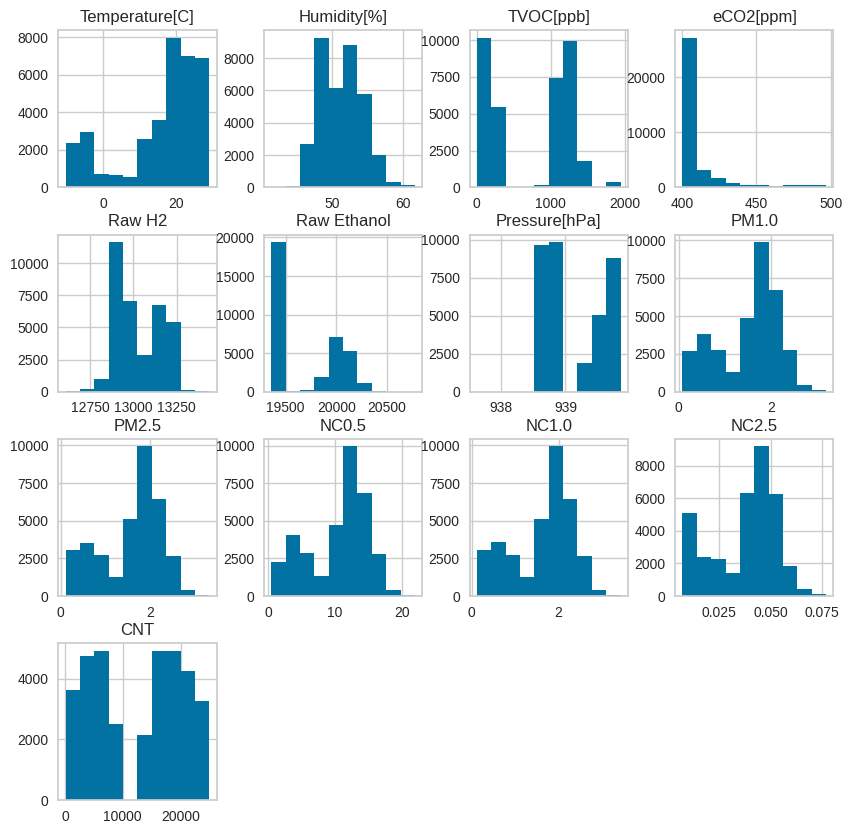

In [ ]:
filtered_data.hist(figsize=(10,10))

Так удачно, видимо, удалили выбросы у поля **CNT**, что его график разделился ровно на две большие части, из-за чего у нас нет ошибок вообще...

Поскольку так дальше развивать и смотреть модель не интересно (вообще нет неверных ответов, потому даже гридсёрчем нечего подбирать и другие ансамбли сранивать тоже), возьмём неочищенные данные:

### **БЕЗ УДАЛЕНИЕМ ВЫБРОСОВ**

In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [26]:
def classification_metrics(y_pred, y_test):
    print(f'accuracy: {accuracy_score(y_pred, y_test)}')
    print(f'confusion matrix:\n{confusion_matrix(y_pred, y_test)}')

In [76]:
from imblearn.over_sampling import RandomOverSampler 
 
y = data['Fire Alarm'] # filtered_
X = data.drop(['Fire Alarm'], axis=1) #filtered_

X, y = RandomOverSampler(random_state=42).fit_resample(X, y) 

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

In [78]:
y.value_counts()

0    44757
1    44757
Name: Fire Alarm, dtype: int64

In [79]:
simple_model = DecisionTreeClassifier(max_depth=3)
simple_model.fit(X_train, y_train)
y_pred_test = simple_model.predict(X_test)
classification_metrics(y_pred_test, y_test)

accuracy: 0.983243031894096
confusion matrix:
[[8883  279]
 [  21 8720]]


In [80]:
y_pred_train = simple_model.predict(X_train)
classification_metrics(y_pred_train, y_train)

accuracy: 0.9805616455572468
confusion matrix:
[[35710  1249]
 [  143 34509]]


Значения оценок на тестовом и обучающем наборах не сильно отличаются, следовательно, признаков переобучения не наблюдается. Результаты настолько хороши, что даже нет нужды в особенном подборе параметров с помощью GridSearch

*Решающие правила*

In [ ]:
from sklearn.tree import export_text
print(export_text(simple_model))

|--- feature_12 <= 5743.50
|   |--- feature_4 <= 13207.50
|   |   |--- feature_6 <= 933.98
|   |   |   |--- class: True
|   |   |--- feature_6 >  933.98
|   |   |   |--- class: False
|   |--- feature_4 >  13207.50
|   |   |--- feature_6 <= 939.63
|   |   |   |--- class: False
|   |   |--- feature_6 >  939.63
|   |   |   |--- class: True
|--- feature_12 >  5743.50
|   |--- class: True



*Визуализируем*

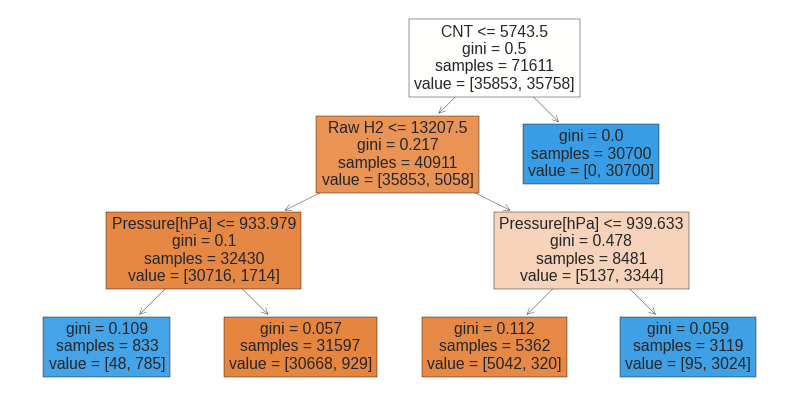

In [ ]:
fig = plt.figure(figsize=(10,5))
_ = tree.plot_tree(simple_model, feature_names=X_train.columns, filled=True)

### Pycaret

In [ ]:
from pycaret.classification import *

In [ ]:
df = pd.read_csv('../data/smoke_detector_task.csv')
df.head()

Unnamed: 0         UTC  Temperature[C]  Humidity[%]  TVOC[ppb]  eCO2[ppm]  \
0           0  1654733331          20.000        57.36        0.0      400.0   
1           1  1654733332          20.015        56.67        0.0      400.0   
2           2  1654733333          20.029        55.96        0.0      400.0   
3           3  1654733334          20.044        55.28        0.0      400.0   
4           4  1654733335          20.059        54.69        0.0      400.0   

    Raw H2  Raw Ethanol  Pressure[hPa]  PM1.0  PM2.5  NC0.5  NC1.0  NC2.5  \
0  12306.0        18520        939.735    0.0    0.0    0.0    0.0    0.0   
1  12345.0        18651        939.744    0.0    0.0    0.0    0.0    0.0   
2  12374.0        18764        939.738    0.0    0.0    0.0    0.0    0.0   
3  12390.0        18849        939.736    0.0    0.0    0.0    0.0    0.0   
4  12403.0        18921        939.744    0.0    0.0    0.0    0.0    0.0   

   CNT Fire Alarm  
0    0         No  
1    1         No  
2    2         No  
3    3         No  
4    4         No

In [ ]:
setup(data=df,  target='Fire Alarm', ignore_features=['Unnamed: 0', 'UTC'] , train_size=0.7, preprocess=True)


In [ ]:
models()

Name  \
ID                                          
lr                    Logistic Regression   
knn                K Neighbors Classifier   
nb                            Naive Bayes   
dt               Decision Tree Classifier   
svm                   SVM - Linear Kernel   
rbfsvm                SVM - Radial Kernel   
gpc           Gaussian Process Classifier   
mlp                        MLP Classifier   
ridge                    Ridge Classifier   
rf               Random Forest Classifier   
qda       Quadratic Discriminant Analysis   
ada                  Ada Boost Classifier   
gbc          Gradient Boosting Classifier   
lda          Linear Discriminant Analysis   
et                 Extra Trees Classifier   
xgboost         Extreme Gradient Boosting   
lightgbm  Light Gradient Boosting Machine   
catboost              CatBoost Classifier   
dummy                    Dummy Classifier   

                                                  Reference  Turbo  
ID                                                                  
lr        sklearn.linear_model._logistic.LogisticRegression   True  
knn       sklearn.neighbors._classification.KNeighborsCl...   True  
nb                           sklearn.naive_bayes.GaussianNB   True  
dt             sklearn.tree._classes.DecisionTreeClassifier   True  
svm       sklearn.linear_model._stochastic_gradient.SGDC...   True  
rbfsvm                             sklearn.svm._classes.SVC  False  
gpc       sklearn.gaussian_process._gpc.GaussianProcessC...  False  
mlp       sklearn.neural_network._multilayer_perceptron....  False  
ridge           sklearn.linear_model._ridge.RidgeClassifier   True  
rf          sklearn.ensemble._forest.RandomForestClassifier   True  
qda       sklearn.discriminant_analysis.QuadraticDiscrim...   True  
ada       sklearn.ensemble._weight_boosting.AdaBoostClas...   True  
gbc         sklearn.ensemble._gb.GradientBoostingClassifier   True  
lda       sklearn.discriminant_analysis.LinearDiscrimina...   True  
et            sklearn.ensemble._forest.ExtraTreesClassifier   True  
xgboost                       xgboost.sklearn.XGBClassifier   True  
lightgbm                    lightgbm.sklearn.LGBMClassifier   True  
catboost                   catboost.core.CatBoostClassifier   True  
dummy                         sklearn.dummy.DummyClassifier   True

In [ ]:
dt = create_model(estimator='dt')
tuned_dt = tune_model(dt)

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


Результат почти равен 1 (0.9997), в то время как у нас на тестовом наборе был 0.983.

## Ансамбли для классификации

*BaggingClassifier*

In [81]:
from sklearn.ensemble import BaggingClassifier

from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC


In [82]:
knn = make_pipeline(StandardScaler(), KNeighborsClassifier())
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
classification_metrics(y_pred, y_test)

accuracy: 0.999720717198235
confusion matrix:
[[8904    5]
 [   0 8994]]


In [83]:
gauss = make_pipeline( GaussianNB())
gauss.fit(X_train, y_train)
y_pred = gauss.predict(X_test)
classification_metrics(y_pred, y_test)

accuracy: 0.6923979221359549
confusion matrix:
[[3631  234]
 [5273 8765]]


In [90]:
log_regression = make_pipeline(StandardScaler(), LogisticRegression())
log_regression.fit(X_train, y_train)
y_pred = log_regression.predict(X_test)
classification_metrics(y_pred, y_test)

accuracy: 0.9836898843769201
confusion matrix:
[[8808  196]
 [  96 8803]]


In [95]:
svm = make_pipeline(StandardScaler(), LinearSVC())
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
classification_metrics(y_pred, y_test)

accuracy: 0.9806736301178574
confusion matrix:
[[8806  248]
 [  98 8751]]


In [ ]:
def bagging_predictions(estimator):
    regr = BaggingClassifier(base_estimator=estimator,
                            n_estimators=10,
                            max_samples=1.0,
                            bootstrap=True, # Samples are drawn with replacement
                            n_jobs= -1,
                            random_state= 43).fit(X_train, y_train)

    br_y_pred = regr.predict(X_test)
    return br_y_pred

In [ ]:
predictions = np.column_stack((bagging_predictions(knn), # составляет их столбами поэлементно
                              bagging_predictions(gauss),
                              bagging_predictions(log_regression),
                              bagging_predictions(svm)))
predictions   

/home/timofey/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/timofey/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

array([[ True,  True,  True,  True],
       [False,  True, False, False],
       [False,  True, False, False],
       ...,
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

In [ ]:
from statistics import mode

In [ ]:
y_pred = [mode(x) for x in predictions]


In [ ]:
classification_metrics(y_pred, y_test)

accuracy: 0.9942467742836396
confusion matrix:
[[8876   75]
 [  28 8924]]


In [ ]:
classif_ensables_scores = {"BaggingClassifier": accuracy_score(y_pred, y_test)}

*GradientBoostingClassifier*

In [16]:
from sklearn.ensemble import GradientBoostingClassifier

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
classif = pd.read_csv("../data/classification_preprocessed_data")

X = classif.drop(columns= 'Fire Alarm')
y = classif['Fire Alarm']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .3)

In [18]:
gradient_boosting_classifier= GradientBoostingClassifier(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4,
                                   min_samples_leaf=15, min_samples_split=10, 
                                   random_state = 42)

In [19]:
gradient_boosting_classifier.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.05, max_depth=4, min_samples_leaf=15,
                           min_samples_split=10, n_estimators=3000,
                           random_state=42)

In [27]:
y_pred = gradient_boosting_classifier.predict(X_test)

classification_metrics(y_pred, y_test)

accuracy: 0.9997871094789504
confusion matrix:
[[ 5434     0]
 [    4 13351]]


Очень точный результат, даже обрезает необходимость подключать автоматизированный поиск гиперпараметров

In [28]:
import joblib

joblib.dump(gradient_boosting_classifier, "../models/MODEL_THREE_gradient_boosting_classifier")

['../models/MODEL_THREE_gradient_boosting_classifier']

In [29]:
test = joblib.load("../models/MODEL_THREE_gradient_boosting_classifier")

In [30]:
y_pred = test.predict(X_test)
classification_metrics(y_pred, y_test)

accuracy: 0.9997871094789504
confusion matrix:
[[ 5434     0]
 [    4 13351]]


*StackingClassifier*

In [87]:
from sklearn.ensemble import StackingClassifier

In [96]:
estimators = [ ('knn', knn), ('logistic_regression', log_regression),('Naive Bayes', gauss) ]
stacking_class = StackingClassifier(estimators=estimators, final_estimator= svm, cv= 5, 
                  n_jobs= -1, # this param cotrols th parallel processing, -1 means using all processors 
                  passthrough = True)
stacking_class.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('knn',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('kneighborsclassifier',
                                                 KNeighborsClassifier())])),
                               ('logistic_regression',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('logisticregression',
                                                 LogisticRegression())])),
                               ('Naive Bayes',
                                Pipeline(steps=[('gaussiannb',
                                                 GaussianNB())]))],
                   final_estimator=Pipeline(steps=[('standardscaler',
                                                    StandardScaler()),
                                                   ('linearsvc', LinearSVC())]),
                   n_jobs=-1, passthrough=True)

In [97]:
y_pred = stacking_class.predict(X_test)
classification_metrics(y_pred, y_test)

accuracy: 0.999776573758588
confusion matrix:
[[8904    4]
 [   0 8995]]


Aналогично нет необходимости прибегать к GridSearch

### Catboost, XGBoost, LightGBM (regression)

*Catboost*

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
catboost_class = CatBoostClassifier(loss_function='Logloss', random_state=42)

In [ ]:
catboost_class.fit(    
     X_train,
     y_train,
    #  cat_features=cat_indices,
     eval_set=(X_test, y_test),
     verbose=False,
     plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
y_test.unique()

array([ True, False])

In [ ]:
y_pred = catboost_class.predict(X_test)
y_pred = [bool(value) for value in y_pred]

classification_metrics(y_pred, y_test)

accuracy: 0.5026531866167682
confusion matrix:
[[   0    0]
 [8904 8999]]


*XGBoost*

In [ ]:
from xgboost import XGBClassifier

In [ ]:
X_train.columns

Index(['Temperature[C]', 'Humidity[%]', 'TVOC[ppb]', 'eCO2[ppm]', 'Raw H2',
       'Raw Ethanol', 'Pressure[hPa]', 'PM1.0', 'PM2.5', 'NC0.5', 'NC1.0',
       'NC2.5', 'CNT'],
      dtype='object')

In [ ]:
X_train = X_train.rename(
    columns = {"Temperature[C]": "Temperature", 'Humidity[%]':'Humidity', 'TVOC[ppb]': 'TVOC',
               'eCO2[ppm]': 'eCO2', 'Pressure[hPa]': "Pressure"}
)

In [ ]:
X_test = X_test.rename(
    columns = {"Temperature[C]": "Temperature", 'Humidity[%]':'Humidity', 'TVOC[ppb]': 'TVOC',
               'eCO2[ppm]': 'eCO2', 'Pressure[hPa]': "Pressure"}
)

In [ ]:
xgb_classifier= xgb.XGBClassifier(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213,verbosity=0, nthread = -1, random_state = 42)
xgb_classifier.fit(X_train, y_train)

XGBClassifier(alpha=0.464, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4603, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0468, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1.7817, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=2200, n_jobs=None, nthread=-1, ...)

In [ ]:
y_pred = xgb_classifier.predict(X_test)
classification_metrics(y_pred, y_test)

accuracy: 1.0
confusion matrix:
[[8904    0]
 [   0 8999]]


In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
lgbm_class= lgb.LGBMClassifier()
lgbm_class.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 35758, number of negative: 35853
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 71611, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499337 -> initscore=-0.002653
[LightGBM] [Info] Start training from score -0.002653


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=None, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [ ]:
y_pred = lgbm_class.predict(X_test)
classification_metrics(y_pred, y_test)

accuracy: 0.999944143439647
confusion matrix:
[[8904    1]
 [   0 8998]]


## *Реализация CART*

In [ ]:
class CART:
    """
    Реализация алгоритма дерева решений (CART).

    Параметры:
    - task_type (str): Тип задачи, 'classification' для классификации, 'regression' для регрессии.
    - max_depth (int): Максимальная глубина дерева. Если None, дерево строится до исчерпания данных.
    - min_samples_split (int): Минимальное количество образцов (строк в датасете), необходимых для разделения внутреннего узла.

    Методы:
    - fit(X, y): Обучает модель на обучающих данных X и метках y.
    - predict(X): Прогнозирует метки для новых данных X.

    """

    def __init__(self, task_type='classification', max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.task_type = task_type
        if task_type == 'classification':
            self.impurity_func = lambda x, y: self._gini(x, y)
        elif task_type == 'regression':
            self.impurity_func = lambda x, y: self._mse(x, y)
        else:
            raise ValueError("Неправильный выбор операции!")

    def fit(self, X, y):
        self.root = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        if (self.max_depth is not None and depth >= self.max_depth) or len(X) <= self.min_samples_split:
            leaf_value = np.mean(y) if self.task_type == 'regression' else np.argmax(np.bincount(y)) # возвращает массив с кол-вом каждого числа в массиве начиная с 0
            return {'leaf': True, 'value': leaf_value}

        best_feature, best_threshold = self._find_best_split(X, y)

        if best_feature is None or best_threshold is None:
            leaf_value = np.mean(y) if self.task_type == 'regression' else np.argmax(np.bincount(y))
            return {'leaf': True, 'value': leaf_value}

        left_child_indices = X[:, best_feature] <= best_threshold
        right_child_indices = X[:, best_feature] > best_threshold

        node = {
            'feature': best_feature,
            'threshold': best_threshold,
            'left': self._build_tree(X[left_child_indices], y[left_child_indices], depth + 1),
            'right': self._build_tree(X[right_child_indices], y[right_child_indices], depth + 1)
        }

        return node

    def _find_best_split(self, X, y):
        best_impurity = float('inf') if self.task_type == 'regression' else 1.0
        best_feature = None
        best_threshold = None

        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_indices = X[:, feature] <= threshold
                right_indices = X[:, feature] > threshold

                impurity = self.impurity_func(y[left_indices], y[right_indices])

                if impurity < best_impurity:
                    best_impurity = impurity
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _gini(self, left_y, right_y):
        left_gini = 1 - np.sum((np.bincount(left_y) / len(left_y))**2)  # 1 - sum(proportions)**2
        right_gini = 1 - np.sum((np.bincount(right_y) / len(right_y))**2)
        gini = (len(left_y) * left_gini + len(right_y) * right_gini) / (len(left_y) + len(right_y))
        return gini

    def _mse(self, left_y, right_y):
        left_mse = np.mean((left_y - np.mean(left_y))**2)
        right_mse = np.mean((right_y - np.mean(right_y))**2)
        mse = (len(left_y) * left_mse + len(right_y) * right_mse) / (len(left_y) + len(right_y))
        return mse

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node): #traverse tree for predictions
        if 'leaf' in node:
            return node['value']

        if x[node['feature']] <= node['threshold']:
            return self._traverse_tree(x, node['left'])
        else:
            return self._traverse_tree(x, node['right'])

Let's look at the implemention performance on an example:

### **CART regression**

In [ ]:
data = pd.read_csv('../data/mumbai_houses_task.csv')

data = data.rename(
    columns = {x: '_'.join(x.lower().split()) for x in data.columns}
)

data["furnished_status"] = data["furnished_status"].fillna("Unfurnished")
data["status"] = data["status"].fillna("Ready to Move")

data = data.drop_duplicates().reset_index(drop= True)

float_to_int = {"bedrooms", "bathrooms", "balcony", "parking", "lift"}
for field in float_to_int: 
    data[field] = data[field].astype(int)

dict_neworold = {"New Property": True, "Resale": False}
data["neworold"] = data["neworold"].map(dict_neworold)

dict_status = {"Ready to Move": True, "Under Construction": False}
data["status"] = data["status"].map(dict_status)

dict_furnished = {"Semi-Furnished": 0.5, "Furnished": 1, "Unfurnished": 0} 
data["furnished_status"] = data["furnished_status"].map(dict_furnished)

numeric_data = data.select_dtypes(exclude='object')
object_data = data.select_dtypes(include='object')
data_objects_dummies = pd.get_dummies(object_data)
final_data = pd.concat([numeric_data,data_objects_dummies], axis=1)

y = final_data['price']
X = final_data.drop(['price'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

In [ ]:
regressor = CART(task_type='regression', max_depth=4)
regressor.fit(X_train.values, y_train)
y_pred = regressor.predict(X_test.values)

In [ ]:
r2_score(y_pred, y_test)

0.5754536010779228

### **CART classification**

In [ ]:
data = pd.read_csv('../data/smoke_detector_task.csv')
data = data.drop(['Unnamed: 0'], axis=1)
data = data.drop('UTC', axis=1)

mean_group = ["TVOC[ppb]", "eCO2[ppm]", "PM2.5", 
              "NC1.0", "Humidity[%]", "Temperature[C]",
                "Raw H2", "Pressure[hPa]"]

for field in mean_group:
    data[field] = data[field].fillna(data[field].mean())

dict_firealarm = {"Yes": True, "No": False}
data["Fire Alarm"] = data["Fire Alarm"].map(dict_firealarm)

y = data['Fire Alarm'] # filtered_
X = data.drop(['Fire Alarm'], axis=1) #filtered_

X, y = RandomOverSampler(random_state=42).fit_resample(X, y) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

In [ ]:
classificator = CART(task_type='classification', max_depth=4, min_samples_split=5)
classificator.fit(X_train.values, y_train)
y_pred = classificator.predict(X_test.values)
classification_metrics(y_pred, y_test)

accuracy: 0.9836898843769201
confusion matrix:
[[8808  196]
 [  96 8803]]
